In [1]:
from UTILITY_quickstart import *
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
import numpy as np
from UTILITY_setLattice import setLattice, getBendkG, getQuadkG, getSextkG, setBendkG, setQuadkG, setSextkG, setXOffset, setYOffset


#importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch_baseline2.yml")
importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch_baseline.yml") #This is older but using it to maintain consistency with these slides: https://docs.google.com/presentation/d/1duL8vxZtLYuoekD1mdSnYiVd3wfPsGMSYLjAAmwwFHM/edit?slide=id.g333ecbf07cd_0_79#slide=id.g333ecbf07cd_0_79

tao = initializeTao(
    inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"],   
    csrTF = True,
    numMacroParticles=1e4,
    scratchPath = "/tmp",
    randomizeFileNames = True
)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR on
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_configs/defaults.yml
Number of macro particles = 10000.0
Beam created, written to /tmp/beams/activeBeamFile_17558178461875663935.h5, and reinit to tao


In [2]:
#No magic functions
importedDefaultSettings = importedDefaultSettings | {"centerBC14" : False}

In [3]:
#Optimized lattice: https://docs.google.com/presentation/d/1pEDyfRYzVhJpeqzpDUfJOKxTxE6_achOUj4SHY-MoQQ/edit?slide=id.g35f44d73435_0_76#slide=id.g35f44d73435_0_76
setQuadkG(tao, "QM14891", 28.7587)
setQuadkG(tao, "Q14901",  -19.602)

setQuadkG(tao, "Q15201",  15.516)
setQuadkG(tao, "Q15301", -13.20)
setQuadkG(tao, "Q15401",  11.6321)
setQuadkG(tao, "Q15501",  -7.864)
setQuadkG(tao, "Q15601",  10.6835)
setQuadkG(tao, "Q15701",  -11.723)
setQuadkG(tao, "Q15801",  15.286)
setQuadkG(tao, "Q15901",  -17.215)

## Sanity check : No jitter

In [4]:
tao.cmd("set ele TCY15280 VOLTAGE = 0")
trackBeam(tao, trackEnd = "PR15944", **importedDefaultSettings)
POff = getBeamAtElement(tao, "PR15944")

tao.cmd("set ele TCY15280 PHI0 = 0")
tao.cmd("set ele TCY15280 VOLTAGE = 20e6")
trackBeam(tao, trackEnd = "PR15944", **importedDefaultSettings)
PPlus = getBeamAtElement(tao, "PR15944")

tao.cmd("set ele TCY15280 PHI0 = 0.5")
tao.cmd("set ele TCY15280 VOLTAGE = 20e6")
trackBeam(tao, trackEnd = "PR15944", **importedDefaultSettings)
PMinus = getBeamAtElement(tao, "PR15944")

Fitted line: y = 0.071x + 0.000


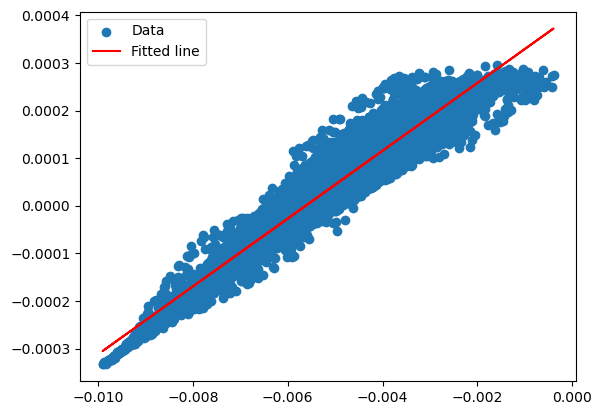

In [5]:
# Fit a line (degree 1 polynomial)
slope, intercept = np.polyfit(PPlus.y, PPlus.z, 1)

# Generate fitted values
y_fit = slope * PPlus.y + intercept

# Print the result
print(f"Fitted line: y = {slope:.3f}x + {intercept:.3f}")

# Plot
plt.scatter(PPlus.y, PPlus.z, label='Data')
plt.plot(PPlus.y, y_fit, color='red', label='Fitted line')
plt.legend()
plt.show()

The measured calibration above of 0.073 beam_zeta / y_screen matches previous work: https://docs.google.com/presentation/d/1duL8vxZtLYuoekD1mdSnYiVd3wfPsGMSYLjAAmwwFHM/edit?slide=id.g333ecbf07cd_0_79#slide=id.g333ecbf07cd_0_79

In [6]:
print( smallestIntervalImpliedSigma(PMinus.y), smallestIntervalImpliedSigma(POff.y), smallestIntervalImpliedSigma(PPlus.y)  )

0.0018201912084829352 0.0004939050037913859 0.001831873668883545


In [7]:
print( smallestIntervalImpliedSigma(POff.z) )

0.00013467813063956134


"2025-05-31 Bunch length fitting.nb" gives
sigma_off = 488 +/- 6.7 um
sigma_z = 127.4 +/- 0.38 um

True values from above are 488 and 134 um respectively 

## Jitter sims

In [8]:
def getLinacMatchStrings(tao):
    """Determine the strings required to match Bmad cavity elements"""
    
    global L1MatchStrings, L2MatchStrings, L3MatchStrings, selectMarkers
    
    #These more general match strings might cause problems by including both lords and slaves!
    L1MatchStrings = ["K11_1*", "K11_2*"]
    L2MatchStrings = ["K11_4*", "K11_5*", "K11_6*", "K11_7*", "K11_8*", "K12_*", "K13_*", "K14_*"]
    L3MatchStrings = ["K15_*", "K16_*", "K17_*", "K18_*", "K19_*"]
    
    #Therefore, use lat_list and these general search strings to get specific elements
    #Recall that, by default, lat_list has the flag "-track_only" so lords are not included
    #But some of the tracking elements are super_slaves which cannot be `set`
    
    #"-array_out" flag is on by default but if flags are edited, need to re-add manually to get numeric values back
    
    L1MatchStrings = np.concatenate( [ tao.lat_list(i,"ele.name", flags="-no_slaves") for i in L1MatchStrings ] )
    L2MatchStrings = np.concatenate( [ tao.lat_list(i,"ele.name", flags="-no_slaves") for i in L2MatchStrings ] )
    L3MatchStrings = np.concatenate( [ tao.lat_list(i,"ele.name", flags="-no_slaves") for i in L3MatchStrings ] )
    
    
    selectMarkers  = np.array(["ENDDL10", "BEGBC11_1", "BC11CEND", "BEGBC14_1", "ENDBC14_2", "BEGBC20", "ENDBC20", "PENT"])
    
    return [L1MatchStrings, L2MatchStrings, L3MatchStrings, selectMarkers]


L1MatchStrings, L2MatchStrings, L3MatchStrings, selectMarkers = getLinacMatchStrings(tao)

L0BMatchStrings = ["L0BF"]

In [10]:
def jitterLinac():
    #Hardcoded numbers from https://docs.google.com/spreadsheets/d/1xeCUImz5uFSq6QA3wV91dG38s-8cyVXQMGw9hjPKa6M/edit?gid=0#gid=0
    
    #Convert to "turns"
    L0BPhaseError = np.random.normal() * 0.1 / 360 
    L1PhaseError = np.random.normal() * 0.7 / 360 
    L2PhaseError = np.random.normal() * 0.4 / 360 

    #Give as multiplier to base gradient
    L0BGradientErrorRelative = np.random.normal() * 0.5 / 100
    L1GradientErrorRelative = np.random.normal() * 0.25 / 100
    L2GradientErrorRelative = np.random.normal() * 0.3 / 100
    
    
    
    [ tao.cmd(f"set ele {ele} PHI0_ERR = {L0BPhaseError}") for ele in L0BMatchStrings ]
    [ tao.cmd(f"set ele {ele} PHI0_ERR = {L1PhaseError}") for ele in L1MatchStrings ]
    [ tao.cmd(f"set ele {ele} PHI0_ERR = {L2PhaseError}") for ele in L2MatchStrings ]

    for ele in L0BMatchStrings:
        baseGradient = tao.ele_gen_attribs(ele)["GRADIENT"]
        specificGradientError = L0BGradientErrorRelative * baseGradient
        tao.cmd(f"set ele {ele} GRADIENT_ERR = {specificGradientError}")

    for ele in L1MatchStrings:
        baseGradient = tao.ele_gen_attribs(ele)["GRADIENT"]
        specificGradientError = L1GradientErrorRelative * baseGradient
        tao.cmd(f"set ele {ele} GRADIENT_ERR = {specificGradientError}")

    for ele in L2MatchStrings:
        baseGradient = tao.ele_gen_attribs(ele)["GRADIENT"]
        specificGradientError = L2GradientErrorRelative * baseGradient
        tao.cmd(f"set ele {ele} GRADIENT_ERR = {specificGradientError}")

In [14]:
for i in range(10):
    
    jitterLinac()
    
    tao.cmd("set ele TCY15280 PHI0 = 0.5")
    tao.cmd("set ele TCY15280 VOLTAGE = 20e6")
    trackBeam(tao, trackEnd = "PR15944", **importedDefaultSettings)
    PMinus = getBeamAtElement(tao, "PR15944")
    
    print(f" -1, {smallestIntervalImpliedSigma(PMinus.y)}")
    
    
    jitterLinac()
    
    tao.cmd("set ele TCY15280 VOLTAGE = 0")
    trackBeam(tao, trackEnd = "PR15944", **importedDefaultSettings)
    POff = getBeamAtElement(tao, "PR15944")
    
    print(f" 0, {smallestIntervalImpliedSigma(POff.y)}")
    
    
    jitterLinac()
    
    
    tao.cmd("set ele TCY15280 PHI0 = 0")
    tao.cmd("set ele TCY15280 VOLTAGE = 20e6")
    trackBeam(tao, trackEnd = "PR15944", **importedDefaultSettings)
    PPlus = getBeamAtElement(tao, "PR15944")
    
    print(f" 1, {smallestIntervalImpliedSigma(PPlus.y)}")

 -1, 0.001463870524947474
 0, 0.00047288595738029726
 1, 0.0015314520018408838
 -1, 0.0015990216946601093
 0, 0.000488025717938945
 1, 0.001702715083358308
 -1, 0.0015840824570475
 0, 0.0004415050596621244
 1, 0.0016658283063040557
 -1, 0.001981712299712555
 0, 0.0005222530245381091
 1, 0.0017697200301395532
 -1, 0.0014666899862966108
 0, 0.00045537560463279814
 1, 0.0018473205035243142
 -1, 0.0013760208707809464
 0, 0.0004859513693057428
 1, 0.00173260856250911
 -1, 0.002051708016449268
 0, 0.0004954909340642246
 1, 0.0010361132520943922
 -1, 0.0019271012186153709
 0, 0.0004533206230957517
 1, 0.001938710604969935
 -1, 0.0017277901577373476
 0, 0.00048823842599653476
 1, 0.0015677181790459992
 -1, 0.0017144755734529442
 0, 0.0004857739148630236
 1, 0.001810528644912713
